In [290]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyrootutils
import hydra
from IPython.display import display

pyrootutils.set_root(os.path.abspath(".."), pythonpath=True)
    
from src.utils.data import load_news, load_behaviors
from src.utils.hydra import RunCollection
from src.evaluation.metrics import gs_score, ild
from src.evaluation.recommender import scoring_functions
from src.utils.notebook import get_figsize, save_to_latex, plot_latex_style

MIN_HISTORY_LENGTH = 3
DIVERSITY_SCORE = gs_score

with hydra.initialize(version_base=None, config_path="../conf"):
    cfg = hydra.compose(config_name="notebook")


In [ ]:
all_runs = RunCollection.from_path("../multirun")\
    .filter_by_job("train_recommender")\
    .filter(lambda run: "final" in run.config.tags)\
    .filter(lambda run: "metrics_dev.csv" in run.list_files()) # only completed runs

assert len(set([run.config.data.mind_variant for run in all_runs])) == 1
mind_variant = all_runs[0].config.data.mind_variant

In [ ]:
# Load news
news = load_news(mind_variant, columns=["category", "subcategory", "title"], data_dir=cfg.data_dir)
news = news.drop(columns="split")

# Add embeddings
embeddings_run = RunCollection.from_path("../outputs").filter_by_job("train_embeddings").one()
metrics = pd.read_csv(embeddings_run.get_file_path("metrics.csv"))
best_epoch = int(metrics.iloc[metrics["P@5"].idxmax()]["epoch"])
print(f"Using topic embeddings from epoch {best_epoch}")
topic_embeddings_path = embeddings_run.get_file_path(f"topic_embeddings_{best_epoch}.feather")
topic_embeddings = pd.read_feather(topic_embeddings_path)
news = news\
    .reset_index()\
    .merge(topic_embeddings, on="subcategory")\
    .set_index("id")

# Load users
behaviors = load_behaviors(mind_variant, ["test"], data_dir="../data")
behaviors["impression_ids"] = behaviors.impressions.apply(lambda impressions: [x.split("-")[0] for x in impressions])
behaviors["clicked"] = behaviors.impressions.apply(lambda impressions: [int(x.split("-")[1]) for x in impressions])
behaviors = behaviors\
    .drop(columns=["time", "impressions", "split"])\
    .set_index("log_id")

users = behaviors\
    .drop_duplicates(subset="user")\
    .set_index("user")\
    .drop(columns=["impression_ids", "clicked"])
users["history_length"] = users["history"].apply(len)
users = users[users["history_length"] >= MIN_HISTORY_LENGTH].copy()

# Calculate user's diversity
reading_history = users.explode("history")
reading_history = reading_history.merge(news, left_on="history", right_index=True)
user_reads = reading_history.groupby("user")
users["diversity"] = user_reads.apply(lambda x: DIVERSITY_SCORE(list(x["embedding"].values)) if len(x) > 1 else None)
users["diversity percentile"] = pd.qcut(users["diversity"], np.linspace(0, 1, 6), labels=np.arange(1, 6)/5)

In [ ]:
def get_metrics(runs, split="dev", best_on="AUC", index_by=None, **kwargs):
    dev_metrics = pd.concat([pd.read_csv(run.get_file_path("metrics_dev.csv")).assign(run=run) for run in runs])
    dev_metrics = dev_metrics.reset_index(drop=True)
    test_metrics = pd.concat([pd.read_csv(run.get_file_path("metrics_test.csv")).assign(run=run) for run in runs])
    test_metrics = test_metrics.reset_index(drop=True)
    best_metrics = test_metrics.loc[dev_metrics.groupby("run")[best_on].idxmax()]
    for key, value in kwargs.items():
        best_metrics[key] = best_metrics["run"].apply(value)
    if index_by:
        best_metrics = best_metrics.set_index(index_by, drop=True).sort_index()
    return best_metrics


def load_predictions(x, split="test"):
    run = x.iloc[0]["run"]
    best_epoch = x.iloc[0]["epoch"]
    predictions = pd.read_feather(run.get_file_path(f"probs_{int(best_epoch)}_{split}.feather"))
    result = behaviors.merge(predictions, on="log_id").assign(run=run)
    return x[["run"]].reset_index().merge(result, on="run")


def get_individual_results(metrics, scoring_fns=scoring_functions.keys()):
    results = metrics\
        .groupby("run")\
        .apply(load_predictions)\
        .reset_index(drop=True)

    for key in scoring_fns:
        results[key] = results.apply(lambda row: scoring_functions[key](row.clicked, row.probs), axis=1)
        
    return results

## Baseline

In [288]:
use_history_mask = {
    "naml": False,
    "nrms": True,
    "tanr": False,
}

baseline_runs = {
    model: all_runs\
        .filter_by_override("+experiment", "baseline")\
        .filter_by_override("+model", model)\
        .filter_by_config_value("use_history_mask", use_history_mask[model])
    for model in use_history_mask.keys()
}

number_of_seeds = 5
assert all([len(runs) == number_of_seeds for runs in baseline_runs.values()])

baseline_runs = [run for runs in baseline_runs.values() for run in runs]
baseline_metrics = get_metrics(baseline_runs, split="test", index_by="model", model=lambda run: run.overrides["+model"].upper())
baseline_metrics = baseline_metrics.drop(columns=["run", "epoch"]) * 100
baseline_metrics = baseline_metrics.groupby("model").agg(["mean", "std"])
baseline_metrics

AUC                  MRR               NDCG@5            \
            mean       std       mean       std       mean       std   
model                                                                  
NAML   67.885566  0.479370  32.477128  0.476706  36.089210  0.551606   
NRMS   67.658070  0.192254  32.698183  0.061747  36.113365  0.120585   
TANR   66.804456  0.259989  31.835823  0.145106  35.207147  0.181556   

         NDCG@10            
            mean       std  
model                       
NAML   42.460134  0.487243  
NRMS   42.487750  0.130547  
TANR   41.563421  0.171887

In [ ]:
save_to_latex(
    cfg.tables_dir,
    "baseline_performance",
    baseline_metrics\
        .groupby(level=0, axis=1, sort=False).apply(merge_mean_and_std)\
        .reset_index()\
        .rename(columns={
            "model": "Model",
            "NDCG@5": "nDCG@5",
            "NDCG@10": "nDCG@10",
        })\
        .style,
    caption="Performance of baseline methods. Standard deviation in parentheses."
)

In [ ]:
metrics = ["AUC", "MRR"]
results = get_individual_results(
    get_metrics(baseline_runs, index_by="model", model=lambda run: run.overrides["+model"].upper()),
    metrics
)
averaged_per_user = results\
    .groupby(["model", "user"])\
    .agg({key: "mean" for key in metrics})\
    .reset_index()\
    .merge(users, left_on="user", right_index=True)
averaged_per_percentile = averaged_per_user\
    .groupby(["model", "diversity percentile"])\
    .agg({key: "mean" for key in metrics})
averaged_per_percentile = averaged_per_percentile * 100

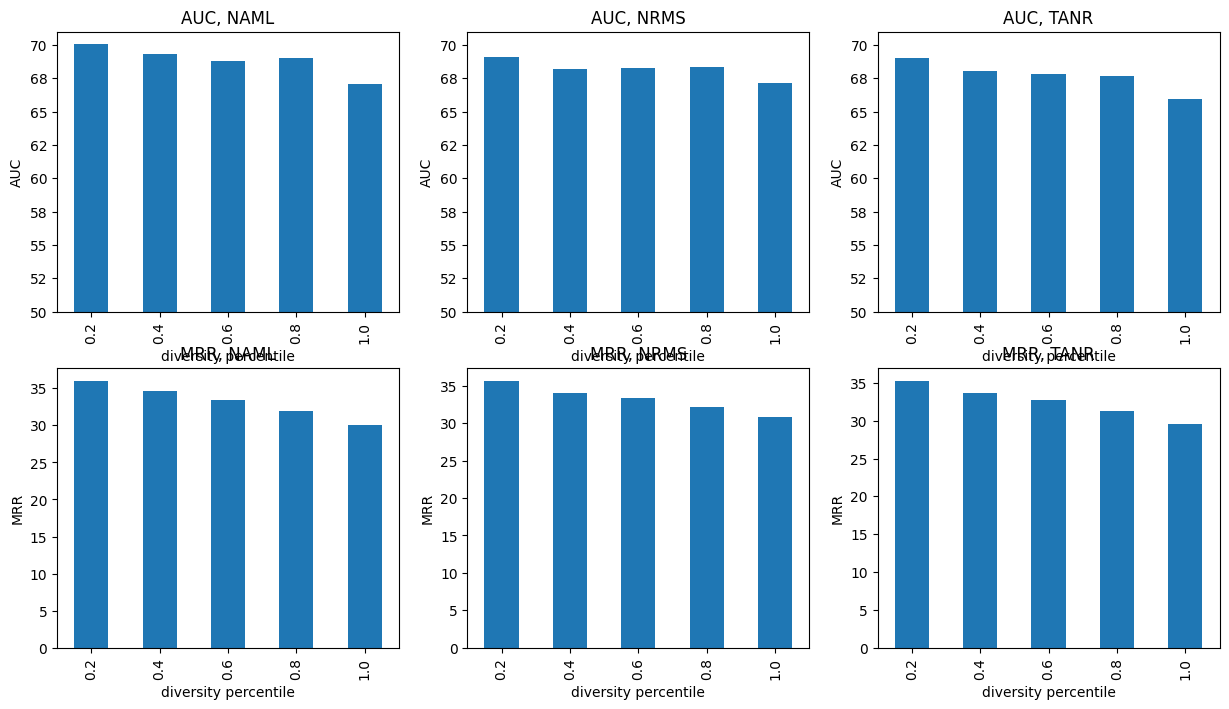

In [372]:
models = averaged_per_percentile.index.unique(0)
metrics = averaged_per_percentile.columns
fig, axs = plt.subplots(len(metrics), len(models), figsize=(15, 8))
for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        averaged_per_percentile.loc[model][metric].plot.bar(ax=axs[i,j], ylabel=metric, title=f"{metric}, {model}")
        if metric == "AUC":
            axs[i,j].set_ylim((50, 71))
            axs[i,j].yaxis.set_major_formatter('{x:.0f}')

In [ ]:
with plot_latex_style():
    models = averaged_per_percentile.index.unique(0)
    metrics = averaged_per_percentile.columns
    for i, metric in enumerate(metrics):
        for j, model in enumerate(models):
            fig, ax = plt.subplots(figsize=get_figsize(fraction=0.48))
            averaged_per_percentile.loc[model][metric].plot.bar(ax=ax, ylabel=metric, rot=0, width=0.65, color="#956CB4")
            if metric == "AUC":
                ax.set_ylim((50, 71))
                ax.yaxis.set_major_formatter('{x:.0f}')
            ax.set_axisbelow(True)
            ax.grid(axis="y")
            plt.savefig(os.path.join(cfg.images_dir, f"diversity_corr_{model}_{metric}.pdf"), format="pdf", bbox_inches="tight")
            plt.clf()

In [294]:
correlation = averaged_per_user\
    .groupby("model")\
    .apply(lambda x: x[["AUC", "MRR", "diversity"]].corr())\
    .drop(columns="diversity")\
    .drop(index=["AUC", "MRR"], level=1)\
    .unstack(level=1)
correlation

,AUC,MRR
,diversity,diversity
model,,
NAML,-0.032173,-0.069148
NRMS,-0.018684,-0.056699
TANR,-0.032633,-0.067741


In [ ]:
save_to_latex(
    cfg.tables_dir,
    "baseline_performance_diversity_corr",
    correlation\
        .reset_index()\
        .droplevel(level=1, axis=1)\
        .rename(columns={
            "model": "Model",
            "AUC": r"AUC \& diversity",
            "MRR": r"MRR \& diversity"
        })
        .style.format(precision=3),
    caption="Correlation between users' reading diversity and recommendation performance."
)

## Effect of adding multi-interest

In [295]:
hierec_use_history_mask = {
    "naml": True,
    "nrms": True,
    "tanr": True,
}

hierec_runs = {
    model: all_runs\
        .filter_by_override("+experiment", f"{model}_hierec")\
        .filter_by_config_value("use_history_mask", hierec_use_history_mask[model])
    for model in hierec_use_history_mask.keys()
}

number_of_seeds = 5
assert all([len(runs) == number_of_seeds for runs in hierec_runs.values()])

hierec_runs = [run for runs in hierec_runs.values() for run in runs]
hierec_metrics = get_metrics(hierec_runs, split="test", index_by="model", model=lambda run: run.overrides["+experiment"].split("_")[0].upper())
hierec_metrics = hierec_metrics.drop(columns=["run", "epoch"]) * 100
hierec_metrics = hierec_metrics.groupby("model").agg(["mean", "std"])
hierec_metrics

AUC                  MRR               NDCG@5            \
            mean       std       mean       std       mean       std   
model                                                                  
NAML   67.274260  0.363121  31.983583  0.236604  35.420655  0.233473   
NRMS   67.376637  0.456953  32.766562  0.228936  36.247849  0.291423   
TANR   67.129085  0.295511  32.231780  0.248136  35.658709  0.261200   

         NDCG@10            
            mean       std  
model                       
NAML   41.915494  0.281092  
NRMS   42.629251  0.281542  
TANR   42.124682  0.222325

In [296]:
multi_interest_hparams = {
    "naml": (False, 64),
    "nrms": (False, 16),
    "tanr": (True, 64)
}

multi_interest_runs = {
    model: all_runs\
        .filter_by_override("+experiment", f"{model}_multi_interest")\
        .filter_by_config_value("use_history_mask", multi_interest_hparams[model][0])\
        .filter_by_config_value("model.user_encoder.n_interest_vectors", multi_interest_hparams[model][1])
    for model in multi_interest_hparams.keys()
}

number_of_seeds = 5
assert all([len(runs) == number_of_seeds for runs in multi_interest_runs.values()])

multi_interest_runs = [run for runs in multi_interest_runs.values() for run in runs]
multi_interest_metrics = get_metrics(multi_interest_runs, split="test", index_by="model", model=lambda run: run.overrides["+experiment"].split("_")[0].upper())
multi_interest_metrics = multi_interest_metrics.drop(columns=["run", "epoch"]) * 100
multi_interest_metrics = multi_interest_metrics.groupby("model").agg(["mean", "std"])
multi_interest_metrics

AUC                  MRR               NDCG@5            \
            mean       std       mean       std       mean       std   
model                                                                  
NAML   67.056700  0.637287  31.802326  0.557331  35.024556  0.757569   
NRMS   66.636270  0.430896  32.069225  0.187098  35.295801  0.261000   
TANR   65.422472  0.512182  30.876011  0.379712  33.994582  0.427931   

         NDCG@10            
            mean       std  
model                       
NAML   41.515132  0.665605  
NRMS   41.631861  0.260460  
TANR   40.316904  0.286398

In [370]:
metrics = pd.concat([
    baseline_metrics.assign(user_encoder="Original"),
    hierec_metrics.assign(user_encoder="Hierarchical User Interest"),
    multi_interest_metrics.assign(user_encoder="Multi User Interest")
])
metrics = metrics\
    .rename(columns={"user_encoder": "User modeling"})\
    .set_index("User modeling", append=True)\
    .sort_index(level=0, sort_remaining=False)
metrics

AUC                  MRR            \
                                       mean       std       mean       std   
model User modeling                                                          
NAML  Original                    67.885566  0.479370  32.477128  0.476706   
      Hierarchical User Interest  67.274260  0.363121  31.983583  0.236604   
      Multi User Interest         67.056700  0.637287  31.802326  0.557331   
NRMS  Original                    67.658070  0.192254  32.698183  0.061747   
      Hierarchical User Interest  67.376637  0.456953  32.766562  0.228936   
      Multi User Interest         66.636270  0.430896  32.069225  0.187098   
TANR  Original                    66.804456  0.259989  31.835823  0.145106   
      Hierarchical User Interest  67.129085  0.295511  32.231780  0.248136   
      Multi User Interest         65.422472  0.512182  30.876011  0.379712   

                                     NDCG@5              NDCG@10            
                                       mean       std       mean       std  
model User modeling                                                         
NAML  Original                    36.089210  0.551606  42.460134  0.487243  
      Hierarchical User Interest  35.420655  0.233473  41.915494  0.281092  
      Multi User Interest         35.024556  0.757569  41.515132  0.665605  
NRMS  Original                    36.113365  0.120585  42.487750  0.130547  
      Hierarchical User Interest  36.247849  0.291423  42.629251  0.281542  
      Multi User Interest         35.295801  0.261000  41.631861  0.260460  
TANR  Original                    35.207147  0.181556  41.563421  0.171887  
      Hierarchical User Interest  35.658709  0.261200  42.124682  0.222325  
      Multi User Interest         33.994582  0.427931  40.316904  0.286398

In [ ]:
save_to_latex(
    cfg.tables_dir,
    "multi_interest_performance",
    metrics\
        .groupby(level=0, axis=1, sort=False).apply(merge_mean_and_std)\
        .reset_index()\
        .rename(columns={
            "model": "Model",
            "NDCG@5": "nDCG@5",
            "NDCG@10": "nDCG@10",
        })\
        .style,
    caption="Performance of methods with different user modeling techniques. Standard deviation in parentheses."
)

/var/folders/3q/7f188swx3y544hqm90lsv6mh0000gn/T/ipykernel_76597/1565410985.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  metrics.unstack()["AUC", "mean"].reindex(index, axis=1).plot.bar(


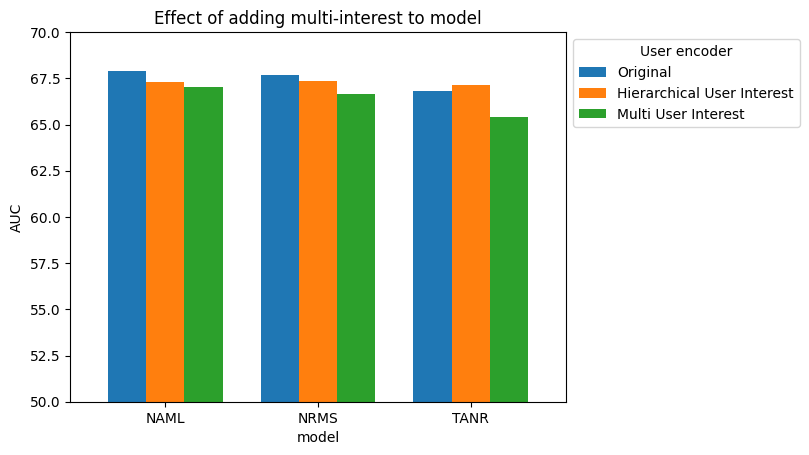

In [371]:
index = metrics.index.get_level_values(1).unique()
metrics.unstack()["AUC", "mean"].reindex(index, axis=1).plot.bar(
    ylim=(50, 70), ylabel="AUC", rot=0, width=0.75,
    title="Effect of adding multi-interest to model"
)
plt.legend(title="User encoder", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
metrics = ["AUC", "MRR"]
h_results = get_individual_results(
    get_metrics(hierec_runs, index_by="model", model=lambda run: run.overrides["+experiment"].split("_")[0].upper()),
    metrics
)
h_averaged_per_user = h_results\
    .groupby(["model", "user"])\
    .agg({key: "mean" for key in metrics})\
    .reset_index()\
    .merge(users, left_on="user", right_index=True)
h_averaged_per_percentile = h_averaged_per_user\
    .groupby(["model", "diversity percentile"])\
    .agg({key: "mean" for key in metrics})
h_averaged_per_percentile = h_averaged_per_percentile * 100

In [ ]:
metrics = ["AUC", "MRR"]
m_results = get_individual_results(
    get_metrics(multi_interest_runs, index_by="model", model=lambda run: run.overrides["+experiment"].split("_")[0].upper()),
    metrics
)
m_averaged_per_user = m_results\
    .groupby(["model", "user"])\
    .agg({key: "mean" for key in metrics})\
    .reset_index()\
    .merge(users, left_on="user", right_index=True)
m_averaged_per_percentile = m_averaged_per_user\
    .groupby(["model", "diversity percentile"])\
    .agg({key: "mean" for key in metrics})
m_averaged_per_percentile = m_averaged_per_percentile * 100

In [354]:
all_averaged_per_percentile = pd.concat([
    averaged_per_percentile.assign(user_encoder="Original"),
    h_averaged_per_percentile.assign(user_encoder="Hierarchical User Interest"),
    m_averaged_per_percentile.assign(user_encoder="Poly Attention Multi-Interest")
])
all_averaged_per_percentile = all_averaged_per_percentile.set_index("user_encoder", append=True)

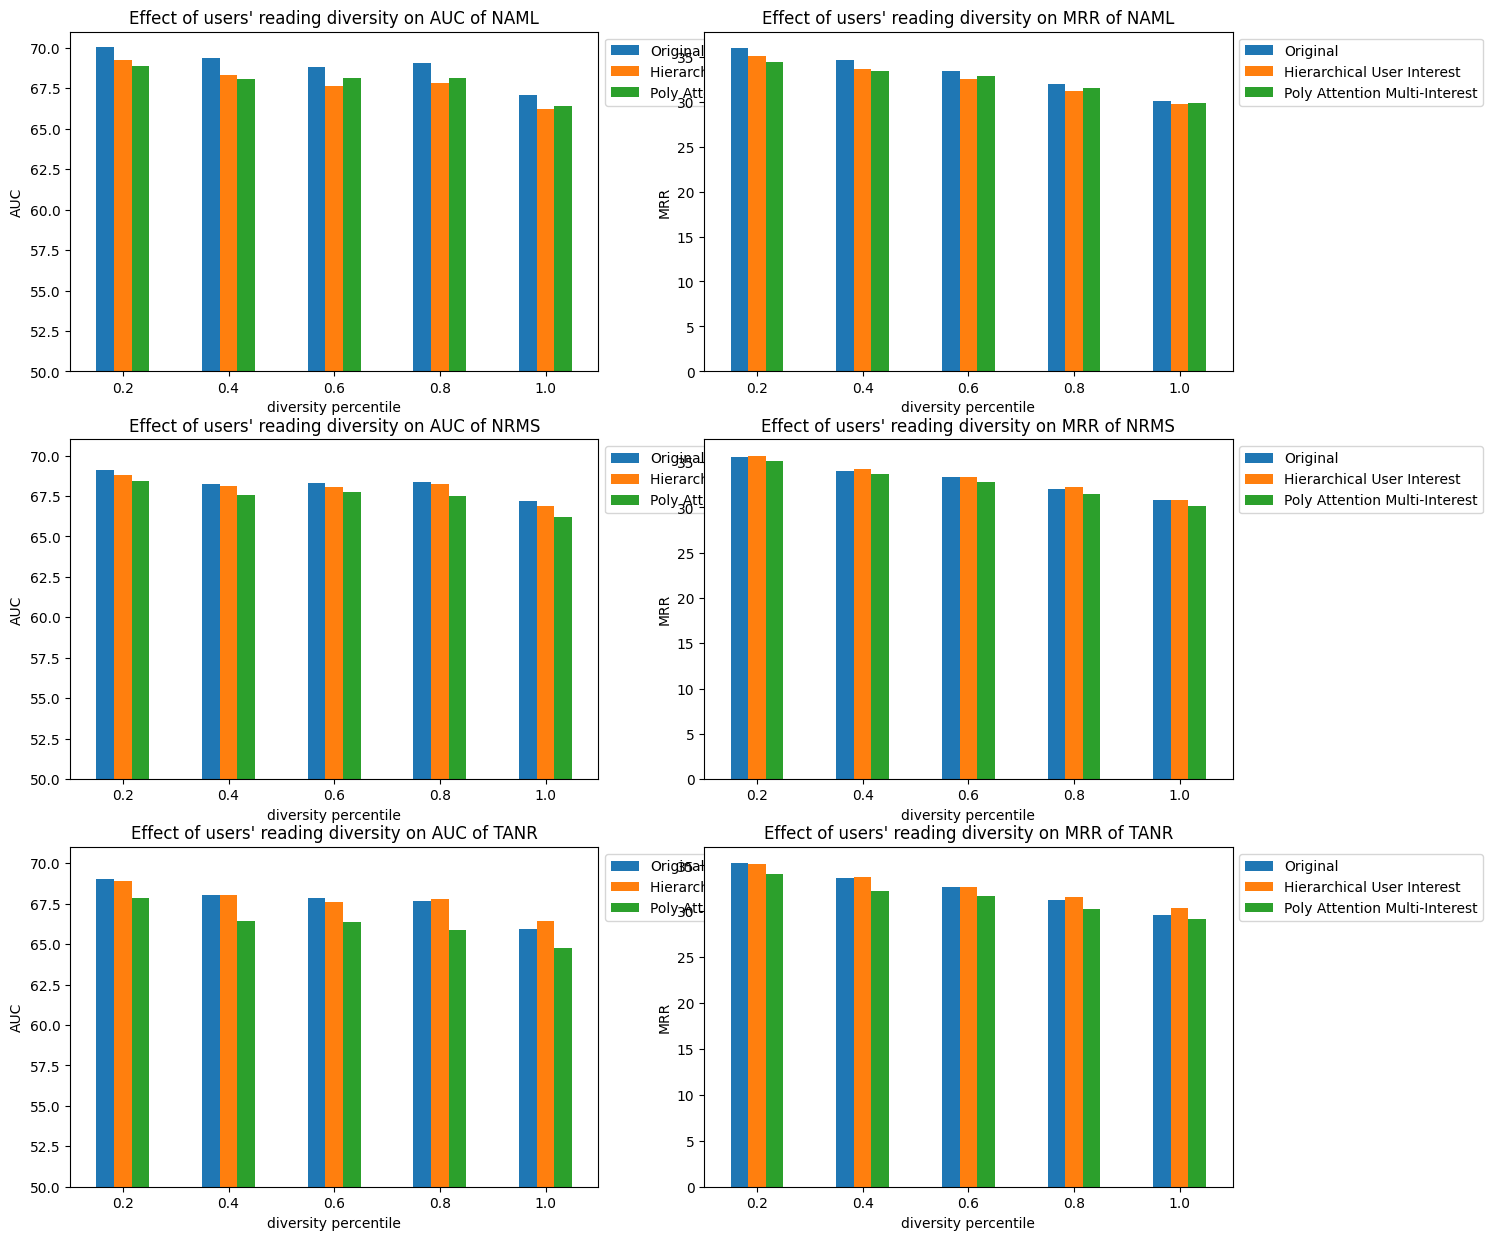

In [369]:
import numpy as np
import matplotlib.ticker as ticker

user_encoders = all_averaged_per_percentile.index.unique(2)
models = all_averaged_per_percentile.index.unique(0)
metrics = all_averaged_per_percentile.columns
fig, axs = plt.subplots(len(models), len(metrics), figsize=(15, 15))
for i, metric in enumerate(metrics):
    for j, model in enumerate(models):
        ax = axs[j, i]
        all_averaged_per_percentile.loc[model][metric]\
            .unstack(level=1)\
            .reindex(user_encoders, axis=1)\
            .plot.bar(ax=ax, ylabel=metric, title=f"Effect of users' reading diversity on {metric} of {model}", rot=0)
        if metric == "AUC":
            ax.set_ylim((50, 71))    
        ax.legend(bbox_to_anchor=(1, 1))

In [359]:
with plot_latex_style():
    plt.ioff()
    user_encoders = all_averaged_per_percentile.index.unique(2)
    models = all_averaged_per_percentile.index.unique(0)
    metrics = all_averaged_per_percentile.columns
    for i, metric in enumerate(metrics):
        for j, model in enumerate(models):
            fig, ax = plt.subplots(figsize=get_figsize(fraction=0.48))
            legend = plt.figure(figsize=get_figsize(fraction=0.3))
            bars = all_averaged_per_percentile.loc[model][metric]\
                .unstack(level=1)\
                .reindex(user_encoders, axis=1)\
                .plot.bar(ax=ax, ylabel=metric, rot=0, legend=False, width=0.7, color=["#956CB4", "#D65F5F", "#D5BB67"])
            if metric == "AUC":
                ax.set_ylim((50, 71))
                ax.yaxis.set_major_formatter('{x:.0f}')
            ax.set_axisbelow(True)
            ax.grid(axis="y")

            legend.legend(*ax.get_legend_handles_labels())
            legend.savefig(os.path.join(cfg.images_dir, f"multi_interest_diversity_corr_legend.pdf"), format="pdf", bbox_inches="tight")

            fig.savefig(os.path.join(cfg.images_dir, f"multi_interest_diversity_corr_{model}_{metric}.pdf"), format="pdf", bbox_inches="tight")

In [341]:
all_averaged_per_user = pd.concat([
    averaged_per_user.assign(user_encoder="Original"),
    h_averaged_per_user.assign(user_encoder="Hierarchical User Interest"),
    m_averaged_per_user.assign(user_encoder="Multi User Interest")
])

user_encoders = all_averaged_per_user.user_encoder.unique()
all_correlation = all_averaged_per_user\
    .groupby(["model", "user_encoder"])\
    .apply(lambda x: x[["AUC", "MRR", "diversity"]].corr())\
    .drop(columns="diversity")\
    .drop(index=["AUC", "MRR"], level=2)\
    .unstack(level=2)\
    .reindex(user_encoders, level=1)\
    
all_correlation.index = all_correlation.index.rename({"user_encoder": "User modeling", "model": "Model"})
all_correlation

AUC       MRR
                                 diversity diversity
Model User modeling                                 
NAML  Original                   -0.032173 -0.069148
      Hierarchical User Interest -0.034202 -0.064754
      Multi User Interest        -0.025885 -0.052874
NRMS  Original                   -0.018684 -0.056699
      Hierarchical User Interest -0.018051 -0.058543
      Multi User Interest        -0.023359 -0.061645
TANR  Original                   -0.032633 -0.067741
      Hierarchical User Interest -0.027215 -0.060090
      Multi User Interest        -0.040792 -0.065040

In [342]:
save_to_latex(
    cfg.tables_dir,
    "multi_interest_performance_diversity_corr",
    all_correlation\
        .reset_index()\
        .droplevel(level=1, axis=1)\
        .rename(columns={
            "AUC": r"AUC \& diversity",
            "MRR": r"MRR \& diversity"
        })
        .style.format(precision=3),
    caption="Correlation between users' reading diversity and recommendation performance for different user modelling techniques."
)